In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.stats import ks_2samp

In [2]:
pic_path = '../local/pictures/'

In [3]:
def remove_duplicates(df):
	"Remove duplicate rows based on 'miRNA_1_name' and 'miRNA_2_name' regardless of order."
	df['pair'] = df.apply(lambda x: tuple(sorted([x['miRNA_1_name'], x['miRNA_2_name']])), axis=1)
	unique_df = df.drop_duplicates(subset='pair').drop(columns='pair')
	return unique_df

def remove_mirna_pairs(df1, df2):
	"""
	Removes from df1 all rows whose (miRNA_1, miRNA_2) pairs (regardless of order)
	are present in df2.
	"""
	# Create a set of tuples for the miRNA pairs in df2
	mirna_pairs = set()
	for _, row in df2.iterrows():
		mirna1 = row['miRNA_1_name']
		mirna2 = row['miRNA_2_name']
		if mirna1 != mirna2:
			mirna_pairs.add(tuple(sorted([mirna1, mirna2])))

	# Filter df1 to remove rows with miRNA pairs present in df2
	filtered_df = df1[~df1.apply(lambda row: tuple(sorted([row['miRNA_1_name'], row['miRNA_2_name']])) in mirna_pairs, axis=1)]
	
	return filtered_df

In [4]:
source = 'ensembl'	# "mgdb_3.0" or "ensembl"
file_path = f'./nw.hsa_{source}_premirna.WGD_flag.intragenic_flag.7mer.s5.tsv'

df = pd.read_csv(file_path, sep='\t', header=None)
cols = ['miRNA_1_name', 'miRNA_2_name', '7mer_s5_nw_score', 'label_1', 'label_2']
df.columns = cols
df

,miRNA_1_name,miRNA_2_name,7mer_s5_nw_score,label_1,label_2
0,Hsa-Mir-33-P1,Hsa-Mir-33-P3,45.0,WGD,WGD_intragenic
1,Hsa-Mir-26-P2,Hsa-Mir-26-P4,46.0,WGD,WGD_intragenic
2,Hsa-Mir-26-P1,Hsa-Mir-26-P4,50.0,WGD,WGD_intragenic
3,Hsa-Mir-26-P1,Hsa-Mir-26-P2,46.0,WGD,WGD_intragenic
4,Hsa-Mir-218-P2,Hsa-Mir-218-P4,49.0,WGD,WGD_intragenic
...,...,...,...,...,...
725,Hsa-Let-7-P1b,Hsa-Let-7-P2b3,44.0,SSD,NaN
726,Hsa-Let-7-P1b,Hsa-Let-7-P2b1,46.0,SSD,NaN
727,Hsa-Let-7-P1b,Hsa-Let-7-P2a3,46.0,SSD,NaN
728,Hsa-Let-7-P1b,Hsa-Let-7-P2a2,48.0,SSD,NaN


In [5]:
# count pairs where the 4th column is "WGD_intragenic"
wgd_intragenic_count = df[df['label_2'] == 'WGD_intragenic'].shape[0]
print(f'Number of intragenic WGD pairs: {wgd_intragenic_count}')
wgd_count = df[df['label_1'] == 'WGD'].shape[0]
print(f'Number of general WGD pairs: {wgd_count}')

Number of intragenic WGD pairs: 12
Number of general WGD pairs: 70


In [6]:
df[df['label_2'] == 'WGD_intragenic']

,miRNA_1_name,miRNA_2_name,7mer_s5_nw_score,label_1,label_2
0,Hsa-Mir-33-P1,Hsa-Mir-33-P3,45.0,WGD,WGD_intragenic
1,Hsa-Mir-26-P2,Hsa-Mir-26-P4,46.0,WGD,WGD_intragenic
2,Hsa-Mir-26-P1,Hsa-Mir-26-P4,50.0,WGD,WGD_intragenic
3,Hsa-Mir-26-P1,Hsa-Mir-26-P2,46.0,WGD,WGD_intragenic
4,Hsa-Mir-218-P2,Hsa-Mir-218-P4,49.0,WGD,WGD_intragenic
5,Hsa-Mir-204-P1,Hsa-Mir-204-P2,46.0,WGD,WGD_intragenic
6,Hsa-Mir-153-P2,Hsa-Mir-153-P1,50.0,WGD,WGD_intragenic
7,Hsa-Mir-148-P4,Hsa-Mir-148-P3,40.0,WGD,WGD_intragenic
8,Hsa-Mir-128-P1,Hsa-Mir-128-P2,49.0,WGD,WGD_intragenic
9,Hsa-Mir-103-P2,Hsa-Mir-103-P4,51.0,WGD,WGD_intragenic


In [7]:
pairs_to_relabel = [
	['Hsa-Mir-199-P1-v1', 'Hsa-Mir-199-P2-v1'],
	['Hsa-Mir-199-P1-v1', 'Hsa-Mir-199-P3-v1'],
	['Hsa-Mir-199-P2-v1', 'Hsa-Mir-199-P3-v1'],
	['Hsa-Mir-196-P3', 'Hsa-Mir-196-P4'], # AKA MIR196-A1 MIR196-A2
	['Hsa-Mir-10-P1c-v1', 'Hsa-Mir-10-P1b-v1'], # AKA MIR10-A MIR10-B
]

for pair in pairs_to_relabel:
	condition = ((df['miRNA_1_name'] == pair[0]) & (df['miRNA_2_name'] == pair[1]) | (df['miRNA_1_name'] == pair[1]) & (df['miRNA_2_name'] == pair[0]))
	df.loc[condition & (df['label_1'] == 'WGD'), 'label_2'] = 'WGD_intragenic'
	
	df.loc[condition & (df['label_1'] == 'SSD'), 'label_2'] = 'WGD_intragenic'
	df.loc[condition & (df['label_1'] == 'SSD'), 'label_1'] = 'WGD'

df[df['label_2'] == 'WGD_intragenic']

,miRNA_1_name,miRNA_2_name,7mer_s5_nw_score,label_1,label_2
0,Hsa-Mir-33-P1,Hsa-Mir-33-P3,45.0,WGD,WGD_intragenic
1,Hsa-Mir-26-P2,Hsa-Mir-26-P4,46.0,WGD,WGD_intragenic
2,Hsa-Mir-26-P1,Hsa-Mir-26-P4,50.0,WGD,WGD_intragenic
3,Hsa-Mir-26-P1,Hsa-Mir-26-P2,46.0,WGD,WGD_intragenic
4,Hsa-Mir-218-P2,Hsa-Mir-218-P4,49.0,WGD,WGD_intragenic
5,Hsa-Mir-204-P1,Hsa-Mir-204-P2,46.0,WGD,WGD_intragenic
6,Hsa-Mir-153-P2,Hsa-Mir-153-P1,50.0,WGD,WGD_intragenic
7,Hsa-Mir-148-P4,Hsa-Mir-148-P3,40.0,WGD,WGD_intragenic
8,Hsa-Mir-128-P1,Hsa-Mir-128-P2,49.0,WGD,WGD_intragenic
9,Hsa-Mir-103-P2,Hsa-Mir-103-P4,51.0,WGD,WGD_intragenic


In [8]:
df[df['label_2'] == 'WGD_intragenic'].shape

(17, 5)

In [9]:
df_wgd = df[df['label_1'] == 'WGD']
df_wgd_intragenic = df_wgd[df_wgd['label_2'] == 'WGD_intragenic']
df_ssd = df[df['label_1'] == 'SSD']

In [10]:
df_wgd = remove_duplicates(df_wgd)
df_wgd_intragenic = remove_duplicates(df_wgd_intragenic)
df_ssd = remove_duplicates(df_ssd)

df_ssd = remove_mirna_pairs(df_ssd, df_wgd_intragenic)
df_ssd = remove_mirna_pairs(df_ssd, df_wgd)

/tmp/ipykernel_21479/2297417357.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pair'] = df.apply(lambda x: tuple(sorted([x['miRNA_1_name'], x['miRNA_2_name']])), axis=1)
/tmp/ipykernel_21479/2297417357.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pair'] = df.apply(lambda x: tuple(sorted([x['miRNA_1_name'], x['miRNA_2_name']])), axis=1)


In [11]:
df_ssd.head(50)

,miRNA_1_name,miRNA_2_name,7mer_s5_nw_score,label_1,label_2
70,Hsa-Mir-92-P2d,Hsa-Mir-92-P1c,42.0,SSD,NaN
71,Hsa-Mir-92-P2d,Hsa-Mir-92-P1a,42.0,SSD,NaN
72,Hsa-Mir-8-P2a,Hsa-Mir-8-P1b,31.0,SSD,NaN
73,Hsa-Mir-8-P2a,Hsa-Mir-8-P1a,40.0,SSD,NaN
74,Hsa-Mir-506-P5b,Hsa-Mir-506-P5a1,35.0,SSD,NaN
75,Hsa-Mir-506-P5b,Hsa-Mir-506-P2b,13.0,SSD,NaN
76,Hsa-Mir-506-P5b,Hsa-Mir-506-P1e,28.0,SSD,NaN
77,Hsa-Mir-506-P5b,Hsa-Mir-506-P1c3,4.0,SSD,NaN
78,Hsa-Mir-506-P5b,Hsa-Mir-506-P1c2,4.0,SSD,NaN
79,Hsa-Mir-506-P5b,Hsa-Mir-506-P1c1,4.0,SSD,NaN


In [12]:
df_wgd_scores = df_wgd['7mer_s5_nw_score'].astype(int)
df_ssd_scores = df_ssd['7mer_s5_nw_score'].astype(int)
df_wgd_intragenic_scores = df_wgd_intragenic['7mer_s5_nw_score'].astype(int)

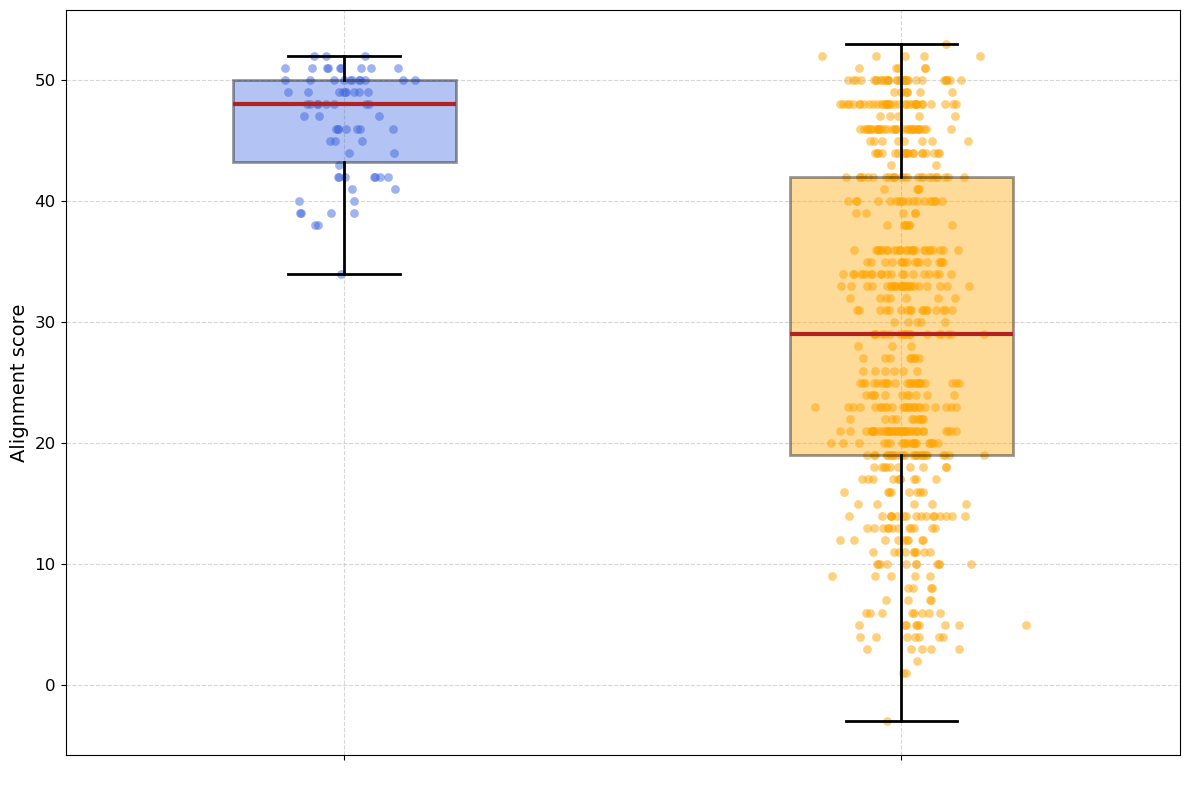

In [13]:
data = [df_wgd_scores, df_ssd_scores]
positions = [0, 1]
colors = ['royalblue', 'orange']

plt.figure(figsize=(12, 8))

box = plt.boxplot(data, 
                  positions=positions, 
                  widths=0.4,
				  #notch=True,
                  patch_artist=True, 
                  showfliers=False)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(2)
    patch.set_alpha(0.4)
    
for element in ['whiskers', 'caps']:
    for line in box[element]:
        line.set_linewidth(2)
        line.set_color('black')
        
for element in ['medians']:
    for line in box[element]:
        line.set_linewidth(3)
        line.set_color('firebrick')

for i, (scores, color) in enumerate(zip(data, colors)):
    jittered_x = np.random.normal(loc=positions[i], scale=0.05, size=len(scores))
    plt.scatter(jittered_x, scores, alpha=0.5, color=color, linewidth=0.2, label=['WGD', 'SSD'][i])

plt.ylabel('Alignment score', fontsize=14)
plt.xticks(positions, [' ', ' '], fontsize=100)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig(f'{pic_path}{source}_true_duplicates_mirgenedbSSD_sequence_similarity_boxplot.png', dpi=300)
plt.show()

In [14]:
ks_statistic, p_value = stats.ks_2samp(data[0], data[1])
print(f'Kolmogorov-Smirnov test statistic: {ks_statistic}, p-value: {p_value}', file=sys.stderr)

NameError: name 'stats' is not defined

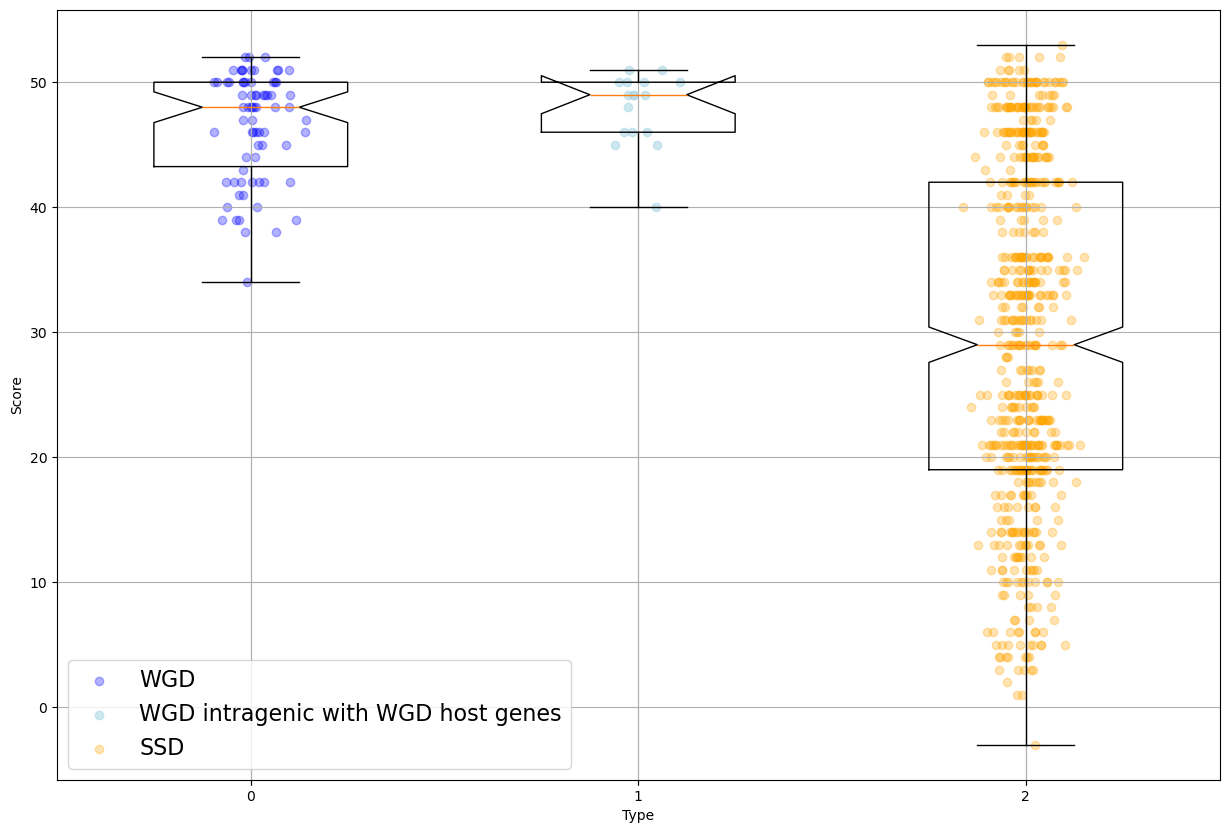

In [ ]:
plt.figure(figsize=(15, 10))
plt.xlabel('Type')
plt.ylabel('Score')
plt.xticks([0, 1, 2], ['WGD', 'WGD intragenic with WGD host genes', 'SSD'])
plt.boxplot([df_wgd_scores, df_wgd_intragenic_scores, df_ssd_scores], positions=[0, 1, 2], widths=0.5, notch=True, showfliers=False)
plt.scatter(np.random.normal(0, 0.05, size=len(df_wgd_scores)), df_wgd_scores, alpha=0.3, color='blue', label='WGD')
plt.scatter(np.random.normal(1, 0.05, size=len(df_wgd_intragenic_scores)), df_wgd_intragenic_scores, alpha=0.6, color='lightblue', label='WGD intragenic with WGD host genes')
plt.scatter(np.random.normal(2, 0.05, size=len(df_ssd_scores)), df_ssd_scores, alpha=0.3, color='orange', label='SSD')
plt.legend(fontsize=16, loc='lower left')
plt.grid()
plt.show()

In [ ]:
print(f'Number of WGD pairs: {len(df_wgd_scores)}')
print(f'Number of WGD intragenic pairs: {len(df_wgd_intragenic_scores)}')
print(f'Number of SSD pairs: {len(df_ssd_scores)}')

Number of WGD pairs: 74
Number of WGD intragenic pairs: 17
Number of SSD pairs: 651


_______________________

In [ ]:
putative_om_path = './ohnomirna_paralogmirna.ssdmirna_wgdmirna_ensembl_check.7mer_s5_align_scores.tarbase_flag.strand_check.tarbase_sd.mirdip_top_sd.mirdip_complete_sd.rbh_wgd.tsv'
putative_pm_path = './ohnomirna_paralogmirna.ssdmirna_wgdmirna_ensembl_check.7mer_s5_align_scores.tarbase_flag.strand_check.tarbase_sd.mirdip_top_sd.mirdip_complete_sd.rbh_ssd.tsv'

df_putative_om_raw = pd.read_csv(putative_om_path, sep='\t', header=0)
df_putative_pm_raw = pd.read_csv(putative_pm_path, sep='\t', header=0)

#df_putative_om_mgdbsingle = df_putative_om_raw[(df_putative_om_raw['miRNA_1_mirgenedb_flag']=='mirgenedb_confirmed') & (df_putative_om_raw['miRNA_2_mirgenedb_flag']=='mirgenedb_confirmed')]
#df_putative_pm_mgdbsingle = df_putative_pm_raw[(df_putative_pm_raw['miRNA_1_mirgenedb_flag']=='mirgenedb_confirmed') & (df_putative_pm_raw['miRNA_2_mirgenedb_flag']=='mirgenedb_confirmed')]

df_putative_om_mgdbsingle = df_putative_om_raw[df_putative_om_raw["miRNA_1_ID"] != df_putative_om_raw["miRNA_2_ID"]]
df_putative_om_mgdbsingle = df_putative_om_mgdbsingle[df_putative_om_mgdbsingle["#_host_gene_1_ID"] != df_putative_om_mgdbsingle["host_gene_2_ID"]]

df_putative_pm_mgdbsingle = df_putative_pm_raw[df_putative_pm_raw["miRNA_1_ID"] != df_putative_pm_raw["miRNA_2_ID"]]
df_putative_pm_mgdbsingle = df_putative_pm_mgdbsingle[df_putative_pm_mgdbsingle["#_host_gene_1_ID"] != df_putative_pm_mgdbsingle["host_gene_2_ID"]]

In [ ]:
df_putative_om_raw

,#_host_gene_1_ID,host_gene_1_name,host_gene_1_strand,miRNA_1_ID,miRNA_1_name,miRNA_1_strand,miRNA_1_tarbase_flag,miRNA_1_mirgenedb_flag,host_gene_2_ID,host_gene_2_name,...,miRNA_2_strand,miRNA_2_tarbase_flag,miRNA_2_mirgenedb_flag,host_genes_LCA,SSD_WGD_flag,miRNA_pair_LCA,7mer_s5_nw_score,tarbase_sd_similarity,mirdip_top_sd_similarity,mirdip_complete_sd_similarity
0,ENSG00000005243,COPZ2,-,ENSG00000207947,MIR152,-,in_tarbase,mirgenedb_confirmed,ENSG00000111481,COPZ1,...,+,in_tarbase,mirgenedb_confirmed,Vertebrata,WGD,Vertebrata,40.0,0.707965,0.809917,0.547120
1,ENSG00000006607,FARP2,+,ENSG00000263752,MIR3133,+,not_in_tarbase,mirgenedb_not_confirmed,ENSG00000152767,FARP1,...,+,not_in_tarbase,mirgenedb_not_confirmed,Vertebrata,WGD,Ensembl_not_verified,-21.0,NaN,0.000000,0.034582
2,ENSG00000012171,SEMA3B,+,ENSG00000283848,MIR6872,+,not_in_tarbase,mirgenedb_not_confirmed,ENSG00000112902,SEMA5A,...,-,not_in_tarbase,mirgenedb_not_confirmed,Vertebrata,WGD,Ensembl_not_verified,2.0,NaN,NaN,0.032333
3,ENSG00000029534,ANK1,-,ENSG00000274705,MIR486-1,-,in_tarbase,mirgenedb_confirmed,ENSG00000145362,ANK2,...,+,not_in_tarbase,mirgenedb_not_confirmed,Vertebrata,WGD,Ensembl_not_verified,3.0,NaN,0.000000,0.038388
4,ENSG00000029534,ANK1,-,ENSG00000274705,MIR486-1,-,in_tarbase,mirgenedb_not_confirmed,ENSG00000145362,ANK2,...,+,not_in_tarbase,mirgenedb_not_confirmed,Vertebrata,WGD,Ensembl_not_verified,3.0,NaN,0.000000,0.038388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,ENSG00000149256,TENM4,-,ENSG00000266570,MIR5579,-,not_in_tarbase,mirgenedb_confirmed,ENSG00000218336,TENM3,...,+,not_in_tarbase,mirgenedb_not_confirmed,Vertebrata,WGD,Ensembl_not_verified,-4.0,NaN,0.000000,0.050691
60,ENSG00000153976,HS3ST3A1,-,ENSG00000221698,MIR548H3,-,in_tarbase,mirgenedb_not_confirmed,ENSG00000182601,HS3ST4,...,+,in_tarbase,mirgenedb_not_confirmed,Vertebrata,WGD,Ensembl_not_verified,39.0,0.403941,0.860681,0.860681
61,ENSG00000154229,PRKCA,+,ENSG00000207943,MIR634,+,in_tarbase,mirgenedb_not_confirmed,ENSG00000166501,PRKCB,...,+,not_in_tarbase,mirgenedb_not_confirmed,Vertebrata,WGD,Ensembl_not_verified,3.0,NaN,0.000000,0.034816
62,ENSG00000197757,HOXC6,+,ENSG00000207924,MIR196A2,+,in_tarbase,mirgenedb_confirmed,ENSG00000260027,HOXB7,...,-,in_tarbase,mirgenedb_confirmed,Bilateria,WGD,Vertebrata,50.0,0.883929,0.933702,0.607460


In [ ]:
col_to_keep = ['miRNA_1_name', 'miRNA_2_name', '7mer_s5_nw_score']
df_putative_om = df_putative_om_raw[col_to_keep]
df_putative_pm = df_putative_pm_raw[col_to_keep]
df_putative_om_mgdbsingle = df_putative_om_mgdbsingle[col_to_keep]
df_putative_pm_mgdbsingle = df_putative_pm_mgdbsingle[col_to_keep]

print(f'Number of putative WGD pairs (raw): {df_putative_om.shape[0]}', file=sys.stderr)
print(f'Number of putative SSD pairs (raw): {df_putative_pm.shape[0]}', file=sys.stderr)
print(f'Number of putative WGD pairs (MGDB single): {df_putative_om_mgdbsingle.shape[0]}', file=sys.stderr)
print(f'Number of putative SSD pairs (MGDB single): {df_putative_pm_mgdbsingle.shape[0]}', file=sys.stderr)

df_putative_om = remove_duplicates(df_putative_om)
df_putative_pm = remove_duplicates(df_putative_pm)
df_putative_om_mgdbsingle = remove_duplicates(df_putative_om_mgdbsingle)
df_putative_pm_mgdbsingle = remove_duplicates(df_putative_pm_mgdbsingle)
df_putative_pm = remove_mirna_pairs(df_putative_pm, df_wgd_intragenic)
df_putative_pm = remove_mirna_pairs(df_putative_pm, df_wgd)
df_putative_pm = remove_mirna_pairs(df_putative_pm, df_putative_om)
df_putative_pm_mgdbsingle = remove_mirna_pairs(df_putative_pm_mgdbsingle, df_wgd_intragenic)
df_putative_pm_mgdbsingle = remove_mirna_pairs(df_putative_pm_mgdbsingle, df_wgd)
df_putative_pm_mgdbsingle = remove_mirna_pairs(df_putative_pm_mgdbsingle, df_putative_om_mgdbsingle)

Number of putative WGD pairs (raw): 64
Number of putative SSD pairs (raw): 301
Number of putative WGD pairs (MGDB single): 64
Number of putative SSD pairs (MGDB single): 301
/tmp/ipykernel_11667/2297417357.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pair'] = df.apply(lambda x: tuple(sorted([x['miRNA_1_name'], x['miRNA_2_name']])), axis=1)
/tmp/ipykernel_11667/2297417357.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pair'] = df.apply(lambda x: tuple(sorted([x['miRNA_1_name'], x['miRNA_2

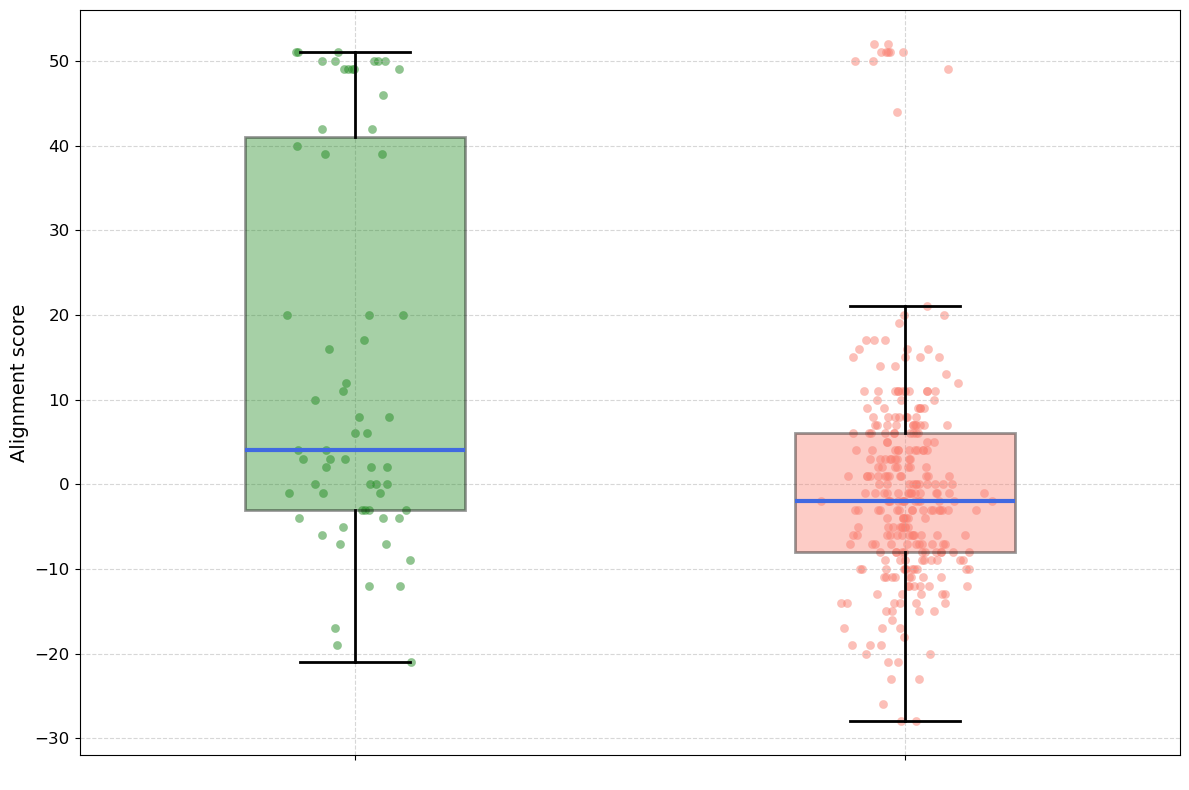

In [ ]:
df_putative_om_scores = df_putative_om['7mer_s5_nw_score'].astype(int)
df_putative_pm_scores = df_putative_pm['7mer_s5_nw_score'].astype(int)

data_putative = [df_putative_om_scores, df_putative_pm_scores]
positions = [0, 1]
colors = ['forestgreen', 'salmon']

plt.figure(figsize=(12, 8))

box = plt.boxplot(data_putative, 
                  positions=positions, 
                  widths=0.4,
				  #notch=True,
                  patch_artist=True, 
                  showfliers=False)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(2)
    patch.set_alpha(0.4)
    
for element in ['whiskers', 'caps']:
    for line in box[element]:
        line.set_linewidth(2)
        line.set_color('black')
        
for element in ['medians']:
    for line in box[element]:
        line.set_linewidth(3)
        line.set_color('royalblue')

for i, (scores, color) in enumerate(zip(data_putative, colors)):
    jittered_x = np.random.normal(loc=positions[i], scale=0.05, size=len(scores))
    plt.scatter(jittered_x, scores, alpha=0.5, color=color, linewidth=0.2, label=['WGD', 'SSD'][i])

plt.ylabel('Alignment score', fontsize=14)
plt.xticks(positions, [' ', ' '], fontsize=100)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig(f'{pic_path}{source}_putative_duplicates_sequence_similarity_boxplot.png', dpi=300)
plt.show()

In [ ]:
ks_stat_1, ks_p_value_1 = ks_2samp(data_putative[0], data_putative[1])
print(f'KS test statistic between WGD and putative WGD: {ks_stat_1}, p-value: {ks_p_value_1}')

KS test statistic between WGD and putative WGD: 0.30976594027441484, p-value: 6.400473312497688e-05


_____________________

## Keep only pairs with MirGeneDB miRNAs (even if they are not paralogues according to MirGeneDB)

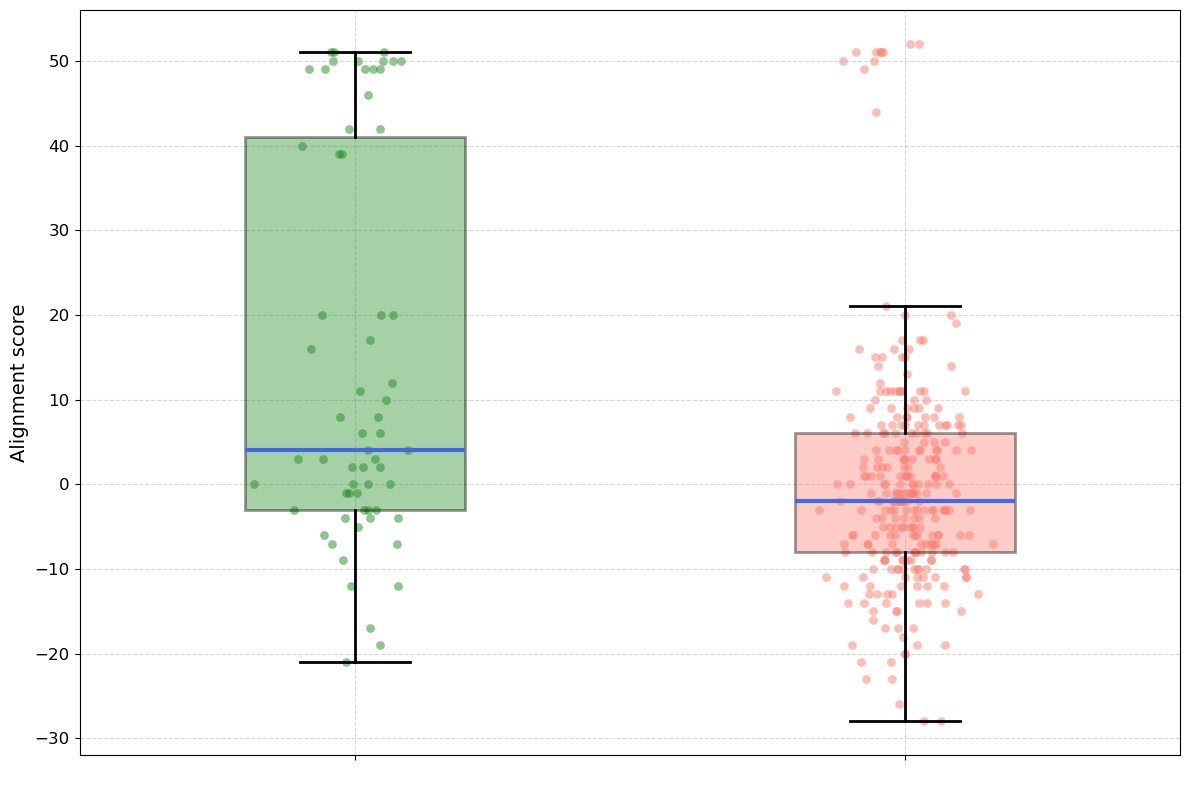

In [ ]:
df_putative_om_mgdbsingle_scores = df_putative_om_mgdbsingle['7mer_s5_nw_score'].astype(int)
df_putative_pm_mgdbsingle_scores = df_putative_pm_mgdbsingle['7mer_s5_nw_score'].astype(int)

data_putative_mgdbsingle = [df_putative_om_mgdbsingle_scores, df_putative_pm_mgdbsingle_scores]
positions = [0, 1]
colors = ['forestgreen', 'salmon']

plt.figure(figsize=(12, 8))

box = plt.boxplot(data_putative_mgdbsingle, 
                  positions=positions, 
                  widths=0.4,
				  #notch=True,
                  patch_artist=True, 
                  showfliers=False)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(2)
    patch.set_alpha(0.4)
    
for element in ['whiskers', 'caps']:
    for line in box[element]:
        line.set_linewidth(2)
        line.set_color('black')
        
for element in ['medians']:
    for line in box[element]:
        line.set_linewidth(3)
        line.set_color('royalblue')

for i, (scores, color) in enumerate(zip(data_putative_mgdbsingle, colors)):
    jittered_x = np.random.normal(loc=positions[i], scale=0.05, size=len(scores))
    plt.scatter(jittered_x, scores, alpha=0.5, color=color, linewidth=0.2, label=['WGD', 'SSD'][i])

plt.ylabel('Alignment score', fontsize=14)
plt.xticks(positions, [' ', ' '], fontsize=100)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig(f'{pic_path}putative_duplicates_mgdbsingle_sequence_similarity_boxplot.png', dpi=300)
plt.show()

In [ ]:
ks_stat_2, ks_p_value_2 = ks_2samp(data_putative_mgdbsingle[0], data_putative_mgdbsingle[1])
print(f'KS test statistic between WGD and putative WGD: {ks_stat_2}, p-value: {ks_p_value_2}')

KS test statistic between WGD and putative WGD: 0.30976594027441484, p-value: 6.400473312497688e-05


____________________________

## MirGeneDB duplicate pairs

In [ ]:
mgdb_duplicates_path = './mgdb_3_hsa.premirna_paralog_pairs.extended_info.tsv'
df_mgdb_duplicates = pd.read_csv(mgdb_duplicates_path, sep='\t', header=None)
# keep only columns 2 and 7
df_mgdb_duplicates = df_mgdb_duplicates[[2, 7]]
df_mgdb_duplicates.columns = ['miRNA_1_name', 'miRNA_2_name']
df_mgdb_duplicates

,miRNA_1_name,miRNA_2_name
0,MIRLET7E,MIRLET7C
1,MIRLET7E,MIRLET7A2
2,MIRLET7E,MIRLET7A1
3,MIRLET7E,MIRLET7A3
4,MIRLET7E,MIRLET7F2
...,...,...
2650,MIR367,MIR25
2651,MIR363,MIR25
2652,MIR96,MIR182
2653,MIR96,MIR183


In [ ]:
df_putative_om_mgdbfiltered = df_putative_om[df_putative_om.apply(lambda row: tuple(sorted([row['miRNA_1_name'], row['miRNA_2_name']])) in set(zip(df_mgdb_duplicates['miRNA_1_name'], df_mgdb_duplicates['miRNA_2_name'])), axis=1)]
df_putative_pm_mgdbfiltered = df_putative_pm[df_putative_pm.apply(lambda row: tuple(sorted([row['miRNA_1_name'], row['miRNA_2_name']])) in set(zip(df_mgdb_duplicates['miRNA_1_name'], df_mgdb_duplicates['miRNA_2_name'])), axis=1)]

Number of putative WGD pairs (MGDB filtered): 5
Number of putative SSD pairs (MGDB filtered): 0


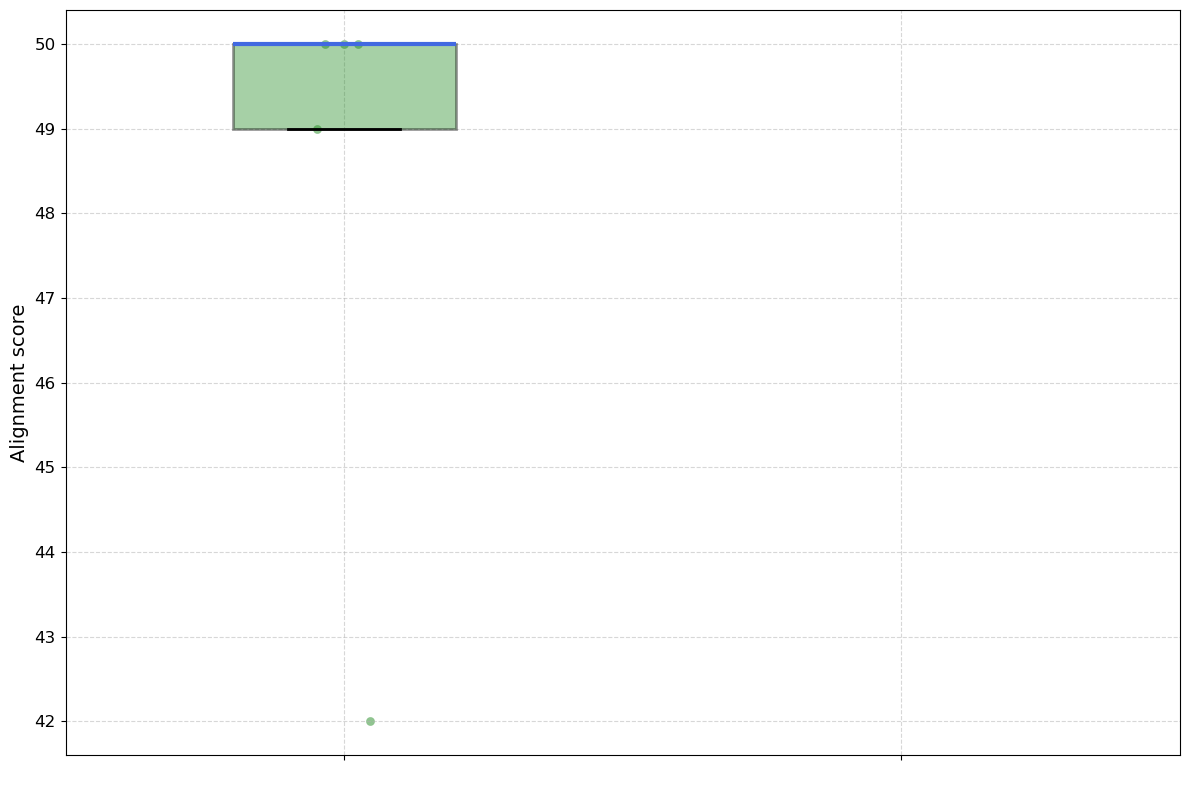

In [ ]:
df_putative_om_mgdbfiltered_scores = df_putative_om_mgdbfiltered['7mer_s5_nw_score'].astype(int)
df_putative_pm_mgdbfiltered_scores = df_putative_pm_mgdbfiltered['7mer_s5_nw_score'].astype(int)

print(f'Number of putative WGD pairs (MGDB filtered): {df_putative_om_mgdbfiltered.shape[0]}', file=sys.stderr)
print(f'Number of putative SSD pairs (MGDB filtered): {df_putative_pm_mgdbfiltered.shape[0]}', file=sys.stderr)

data_putative_mgdbpairs = [df_putative_om_mgdbfiltered_scores, df_putative_pm_mgdbfiltered_scores]
positions = [0, 1]
colors = ['forestgreen', 'salmon']

plt.figure(figsize=(12, 8))

box = plt.boxplot(data_putative_mgdbpairs, 
                  positions=positions, 
                  widths=0.4,
				  #notch=True,
                  patch_artist=True, 
                  showfliers=False)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(2)
    patch.set_alpha(0.4)
    
for element in ['whiskers', 'caps']:
    for line in box[element]:
        line.set_linewidth(2)
        line.set_color('black')
        
for element in ['medians']:
    for line in box[element]:
        line.set_linewidth(3)
        line.set_color('royalblue')

for i, (scores, color) in enumerate(zip(data_putative_mgdbpairs, colors)):
    jittered_x = np.random.normal(loc=positions[i], scale=0.05, size=len(scores))
    plt.scatter(jittered_x, scores, alpha=0.5, color=color, linewidth=0.2, label=['WGD', 'SSD'][i])

plt.ylabel('Alignment score', fontsize=14)
plt.xticks(positions, [' ', ' '], fontsize=100)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()